In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure_size = dict(
    ultra=45,
    large=35,
    middle=20,
    small=10,
    very_small=5
)

def set_plt(figsize=(10, 10)):
    params = {'axes.titlesize': figure_size['ultra'],
              'legend.fontsize': figure_size['middle'],
              'figure.figsize': figsize,
              'axes.labelsize': figure_size['ultra'],
              'xtick.labelsize': figure_size['ultra'],
              'ytick.labelsize': figure_size['ultra'],
              'figure.titlesize': figure_size['ultra'],
              'lines.linewidth': figure_size['very_small']}
    plt.rcParams.update(params)

    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)

def set_Border(axes):
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_linewidth(figure_size['very_small'])
    axes.spines['left'].set_linewidth(figure_size['very_small'])
    axes.tick_params(axis='both', width=figure_size['very_small'], length=figure_size['small'])

In [3]:
def get_significant(file_path):
    significants = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas[1:]:
            data = data.split()
            x, y = int(int(data[1])/1000), int(int(data[3])/1000)
            p_value, q_value = float(data[5]), float(data[6])
            concat = int(data[4])
            significants.append((x, y, p_value, q_value, concat))
    return significants

def cal_significant(significants, proportion):
    test = np.array(significants)
    
    def _filter(_values, max_nums, test):
        values_sort_index = _values.argsort()
        values_min_numbers_index = values_sort_index[max_nums-1]
        p = max_nums
        values_min_indexs = _values.argsort()[:p-1]
        _test = test[values_min_indexs, :]
        return _test

    _p_values = test[:, 2]
    _test = _filter(_p_values, int(_p_values.shape[0]*proportion), test)
    _q_values = _test[:, 3]
    _test = _filter(_q_values, int(_q_values.shape[0]*proportion), _test)
    return _test

In [4]:
_4DNFI1UEG1HD_hr_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/GM12878_ATAC_H3K27ac_H3K4me3/experiment/loop/hr'
_4DNFI1UEG1HD_enhanced_path = '/data1/lmh_data/MINE/additional/fan_only_5/GM12878_ATAC_H3K27ac_H3K4me3/analyse/GM12878_ATAC_H3K27ac_H3K4me3/experiment/loop/enhanced'
_4DNFI7J8BQ4P_enhanced_path = '/data1/lmh_data/MINE/additional/robustness/4DNFI7J8BQ4P/experiment_fan_only_5/loop/enhanced'
_4DNFI9ZWZ5BS_enhanced_path = '/data1/lmh_data/MINE/additional/robustness/4DNFI9ZWZ5BS/experiment_fan_only_5/loop/enhanced'
auxiliary_files_path = '/data1/lmh_data/MINE/source/GM12878'
proportion = 0.015

enhanced_sigs = {
    '4DNFI1UEG1HD': dict(),
    '4DNFI7J8BQ4P': dict(),
    '4DNFI9ZWZ5BS': dict(),
}
hr_sigs = dict()

def get_sig(_path, chrom):
    _path = os.path.join(
        _path, 'chr{}_1000b'.format(chrom), 'outputs_2_100', 'FitHiC.spline_pass1.res1000.significances.txt')
    _sig = cal_significant(get_significant(_path), proportion)
    _sig = set(list(map(tuple, np.array(_sig)[:, :2])))
    return _sig

for chrom in range(1, 23):
    enhanced_sigs['4DNFI1UEG1HD'][chrom] = get_sig(_4DNFI1UEG1HD_enhanced_path, chrom)
    enhanced_sigs['4DNFI7J8BQ4P'][chrom] = get_sig(_4DNFI7J8BQ4P_enhanced_path, chrom)
    enhanced_sigs['4DNFI9ZWZ5BS'][chrom] = get_sig(_4DNFI9ZWZ5BS_enhanced_path, chrom)
    hr_sigs[chrom] = get_sig(_4DNFI1UEG1HD_hr_path, chrom)


In [5]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, enhanced_results, hr_result, title):
    set_plt()
    colors_map = {
        "4DNFI1UEG1HD": (0, 159/255, 232/255),
        "4DNFI7J8BQ4P": (222/255, 28/255, 38/255),
        "4DNFI9ZWZ5BS": (0, 191/255, 82/255),
        "Raw high resolution": (255/255, 122/255, 23/255)
    }
    
    fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
    axes.grid(False)
    for key in enhanced_results.keys():
        axes.plot(x, enhanced_results[key], color=colors_map[key], label=key)
    axes.plot(x, hr_result, color=colors_map['Raw high resolution'], label='Raw high resolution')

    set_Border(axes)
    axes.set_xticks([-40, 0, 40])
    axes.set_xticklabels(['-40K', 'Loop anchor', '40K'])

    plt.ylabel('Number of Peaks')
    plt.legend(
        facecolor='white', loc='upper right', framealpha=0, handletextpad=1, borderpad=0, borderaxespad=0
    ).get_frame().set_linewidth(0.0)
    plt.savefig('figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

def figure(chip_seq_path, title):
    enhanced_results, hr_result = {}, np.zeros(attentions*2-1)
    for key in enhanced_sigs.keys():
        enhanced_results[key] = np.zeros(attentions*2-1)
    _peaks = read_chiqseq_file(chip_seq_path)

    for chr in range(1, 23):
        for key in enhanced_results.keys():
            enhanced_results[key] += get_hit_indicators(enhanced_sigs[key][chr], _peaks['chr{}'.format(chr)])
            hr_result += get_hit_indicators(hr_sigs[chr], _peaks['chr{}'.format(chr)])

    show(list(range(-attentions+1, attentions)), enhanced_results, hr_result, title)

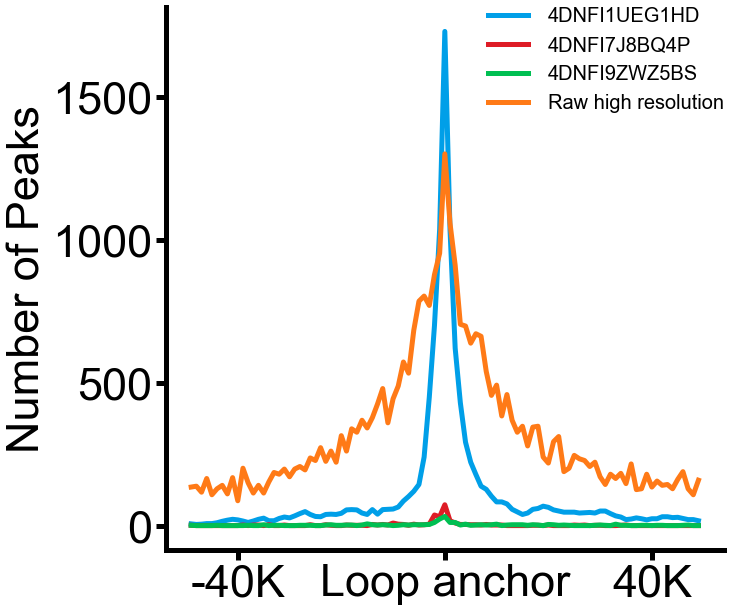

In [6]:
chip_seq_path = os.path.join(auxiliary_files_path, 'CTCF_peaks.bed')
figure(chip_seq_path, 'robustness_CTCF(fan_5)')

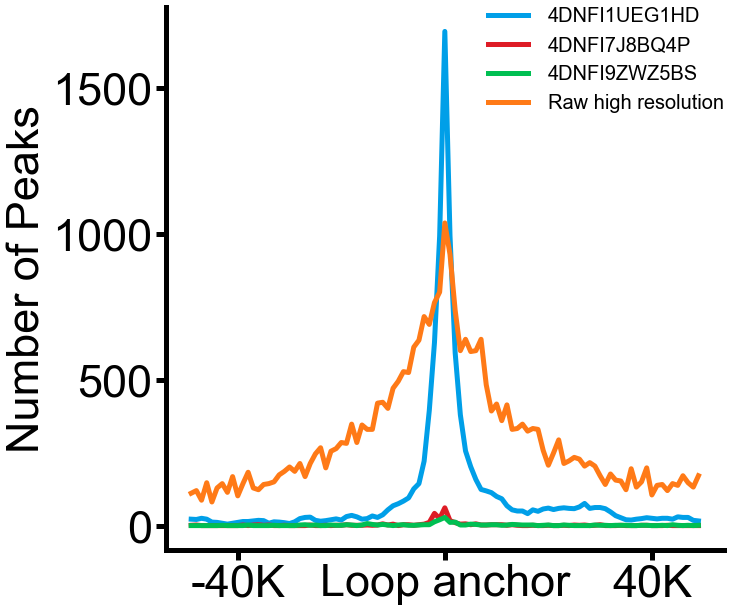

In [7]:
chip_seq_path = os.path.join(auxiliary_files_path, 'RAD21_peaks.bed')
figure(chip_seq_path, 'robustness_RAD21(fan_5)')

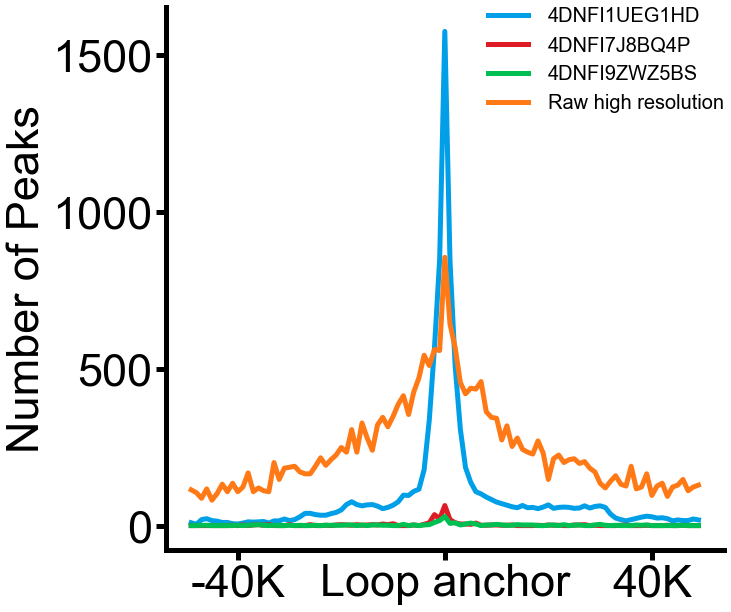

In [8]:
chip_seq_path = os.path.join(auxiliary_files_path, 'SMC3_peaks.bed')
figure(chip_seq_path, 'robustness_SMC3(fan_5)')

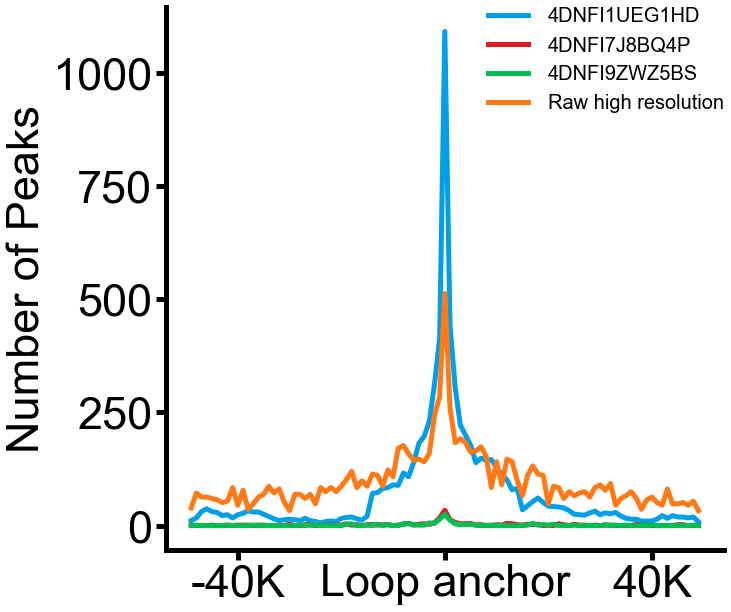

In [9]:
chip_seq_path = os.path.join(auxiliary_files_path, 'POLR2A_peaks.bed')
figure(chip_seq_path, 'robustness_POLR2A(fan_5)')